3.2 - Solve the problem
Alert incident in transactions: Implement the concept of a simple monitoring with real time alert with notifications to teams.

The monitoring works by receiving information about a transaction and inferring whether it is a failed or denied, or reversed or aprroved transaction. We work mostly with SQL, PromQL, Ruby and Python, but you can use any programming language that you want.

Please use the data of this csv and the data of this csv. Consider that transactions with the flag denied are transactions denied by risk of the issuers. Consider that transactions with the flag reversed or failed are transactions with problems. Note: F1 represents the quantity of transactions per minute from all pos from our costumers. So with this data you can see the diferent status per minute and see if it is going well or not. When you see the padron, you can predict a alarm for the anomaly.

Your Monitoring alert system must have at least: 1 endpoint that receives transaction data and returns a recommendation to “alert” the anomalies found in transactions. A query to organize the data on the data and a graphic to see the data in real time. A model to determine anomalies and a system to report the anomalies automatically.

You are free to determine the methods to approve/deny the transactions, but a few ways to do it are:
- rule-based - you define which cases get alerted based on predefined rules;
- score-base - you create a method/model (you could use machine learning models here if you want) to determine the anomaly -- score of a transaction and make your decision based on it;
- a combination of both;

Monitoring alert Requirements
- Alert transactions if failed transactions are above normal;
- Alert transactions if reversed transactions are above normal;
- Alert transactions if denied transactions are above normal;

In [1]:
# EXISTING STATUS BY DATA

import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt

data_1 = pd.read_csv("transactions_1.csv")
data_1[['hour', 'minutes']] = data_1.time.str.split("h ", expand = True)

data_1 = ps.sqldf(f"""
SELECT
    status
FROM
    data_1
GROUP BY
    status
""")
print(data_1)

data_2 = pd.read_csv("transactions_2.csv")
data_2[['hour', 'minutes']] = data_2.time.str.split("h ", expand = True)

data_2 = ps.sqldf(f"""
SELECT
    status
FROM
    data_2
GROUP BY
    status
""")
print(data_2)


             status
0          approved
1  backend_reversed
2            denied
3            failed
4        processing
5          refunded
6          reversed
             status
0          approved
1  backend_reversed
2            denied
3            failed
4        processing
5          refunded
6          reversed


In [2]:
# PLOT CHART BY MINUTE

def plot_graph_min(doc, status, alert=0):

    import pandas as pd
    import pandasql as ps
    import matplotlib.pyplot as plt

    data = pd.read_csv(doc)

    data[['hour', 'minutes']] = data.time.str.split("h ", expand = True)

    data = ps.sqldf("""
        SELECT
            *,
            SUM(count) OVER (PARTITION BY hour, minutes) AS sum_all_count_minute
        FROM
            data
    """)

    data = data[data['status'] == f'{status}']
    data['target'] = data['sum_all_count_minute'] * (alert/100)

    qt_transactions = data.iloc[:,2].values

    plt.figure(figsize=(6,3))
    plt.plot(qt_transactions, linewidth=2, label=f"{status}_{doc}")
    if alert != 0:
        target = data.iloc[:,6].values
        plt.plot(target, linestyle='-.', color='r', linewidth=1, label=f"{status}_target")
    plt.title("Transactions x Time", fontweight="bold")
    plt.xlabel("Minutes")
    plt.xticks([])
    plt.ylabel("Transactions")
    plt.legend()
    plt.savefig('Plots/char', dpi='figure', format=None)
    # plt.show()

In [ ]:
# plot_graph_min('transactions_1.csv', 'failed')
# plot_graph_min('transactions_2.csv', 'failed')
# plot_graph_min('transactions_1.csv', 'reversed')
# plot_graph_min('transactions_2.csv', 'reversed')
# plot_graph_min('transactions_1.csv', 'denied')
# plot_graph_min('transactions_2.csv', 'denied')

In [3]:
# PLOT CHART PER HOUR

def plot_graph_h(doc, status):
    import pandas as pd
    import pandasql as ps
    import matplotlib.pyplot as plt

    data_1 = pd.read_csv(doc)
    data_1[['hour', 'minutes']] = data_1.time.str.split("h ", expand = True)

    data_1_status = ps.sqldf(f"""
    SELECT
        SUM (ALL count) AS 'trans/h'
    FROM
        data_1
    WHERE
        status = '{status}'
    GROUP BY
        hour
    """)

    qt_trans_1 = data_1_status.iloc[:,0].values

    plt.figure(figsize=(20,10))
    plt.plot(qt_trans_1, linewidth=2, label=f"{status}_{doc}")
    plt.title("Transactions x Time", fontweight="bold")
    plt.xlabel("Hour")
    plt.xticks([])
    plt.ylabel("Transactions")
    plt.legend()
    plt.show()

In [ ]:
# plot_graph_h('transactions_1.csv', 'failed')
# plot_graph_h('transactions_2.csv', 'failed')
# plot_graph_h('transactions_1.csv', 'reversed')
# plot_graph_h('transactions_2.csv', 'reversed')
# plot_graph_h('transactions_1.csv', 'denied')
# plot_graph_h('transactions_2.csv', 'denied')

In [4]:
# ALARM SETTING FUNCTION
# rule-based - you define which cases get alerted based on predefined rules

def status_trans_min(doc, status):

    import pandas as pd
    import pandasql as ps

    data = pd.read_csv(doc)

    data_total_minutes = ps.sqldf("""
    SELECT
        COUNT (ALL time) AS "total_minutes_count"
    FROM
        (SELECT DISTINCT time FROM data)
    """)

    data_total_count = ps.sqldf("""
    SELECT
        SUM (ALL count) AS "total_count"
    FROM
        data
    """)

    data_search = ps.sqldf(f"""
    SELECT
        SUM (ALL count) AS "status_count",
        COUNT (ALL count) AS "status_minutes_count"
    FROM
        data
    WHERE
        status = "{status}"
    """)

    total_trans_min = round(float((data_total_count.iloc[:,0].values / data_total_minutes.iloc[:,0].values)), 2)
    status_trans_min = round(float((data_search.iloc[:,0].values / data_search.iloc[:,1].values)), 2)
    status_percent = round(float((status_trans_min / total_trans_min)*100), 2)
    print(f"In the document \033[1m{doc}\033[0;0m \033[1m{status_percent}%\033[0;0m of transactions per minute were \033[1m{status}\033[0; 0m")

In [5]:
status_trans_min('transactions_1.csv', 'failed')
status_trans_min('transactions_2.csv', 'failed')
status_trans_min('transactions_1.csv', 'reversed')
status_trans_min('transactions_2.csv', 'reversed')
status_trans_min('transactions_1.csv', 'denied')
status_trans_min('transactions_2.csv', 'denied')

In the document transactions_1.csv 0.66% of transactions per minute were failed[0; 0m
In the document transactions_2.csv 3.23% of transactions per minute were failed[0; 0m
In the document transactions_1.csv 11.52% of transactions per minute were reversed[0; 0m
In the document transactions_2.csv 0.97% of transactions per minute were reversed[0; 0m
In the document transactions_1.csv 11.9% of transactions per minute were denied[0; 0m
In the document transactions_2.csv 11.06% of transactions per minute were denied[0; 0m


*** DEFINITION OF ALARMS ***

From the percentage values found in the data, I stipulated the premise for the alarm:
- Failed: 0.70% (1 out of every 143 transactions) - Transactions_1
- Reversed: 1.00% (1 every 100 transactions) - Transactions_2
- Denied: 11.50% (1 every 9 transactions) - Average of Transactions_1 and Transactions_2

*** PREMISES ***

1. Alarm per status.
2. It is assumed that there is a .csv file that is updated every minute.

In [6]:
# FUNCTION TO SEND AN E-MAIL ALARM - WITH CHAR

def send_alarm_email(subject, body):
    from email.message import EmailMessage
    from email.mime.multipart import MIMEMultipart
    from email.mime.text import MIMEText
    from email.mime.image import MIMEImage
    import ssl
    import smtplib

    email_sender = 'pedro.cloudwalk@gmail.com'
    email_password = 'cuwqdemdllzqxwgo'
    email_receiver = ['pedro.cloudwalk@gmail.com']

    em = MIMEMultipart("related")
    em['From'] = email_sender
    em['To'] = ", ".join(email_receiver)
    em['Subject'] = subject

    html_body = """
    <html>
    <body>
    <h1>{}</h1>
    <p>{}</p>
    <img src="cid:image1">
    </body>
    </html>
    """.format(subject, body)

    em.attach(MIMEText(html_body, "html"))

    with open('Plots/char.png', 'rb') as image_file:
        image_data = image_file.read()
        image = MIMEImage(image_data)
        image.add_header('Content-ID', '<image1>')
        em.attach(image)

    context = ssl.create_default_context()

    with smtplib.SMTP_SSL('smtp.gmail.com', 465, context=context) as smtp:
        smtp.login(email_sender, email_password)
        smtp.sendmail(email_sender, email_receiver, em.as_string())

In [7]:
# FUNCTION FOR ALARM - LAST MINUTE ANALYSIS

def status_trans_min(doc, status, new_lines):

    import pandas as pd
    import pandasql as ps

    data = pd.read_csv(doc)

    data_total_count = ps.sqldf(f"""
    SELECT
        SUM(count) AS "total__count"
    FROM (
        SELECT count
        FROM data
        ORDER BY time DESC
        LIMIT {new_lines})
    """)

    data_search = ps.sqldf(f"""
    SELECT
        SUM(count) AS "status__count" 
    FROM (
        SELECT status, count
        FROM data
        ORDER BY time DESC
        LIMIT {new_lines})
        WHERE status = "{status}"
    """)

    total_trans_min = round(float((data_total_count.iloc[:,0].values / 1)), 2)
    if data_search.iloc[:,0].values != None:
        status_trans_min = round(float((data_search.iloc[:,0].values / 1)), 2)
        status_percent = round(float((status_trans_min / total_trans_min)*100), 2)

        if status == 'failed':
            alert = 0.70
        elif status == 'reversed':
            alert = 1.00
        elif status == 'denied':
            alert = 11.50

        if status_percent > alert:
            plot_graph_min(doc, status, alert)
            subject = f"ALERT - {status} transactions are above normal!"
            body = f"ATENTION!!!\n\n{status} activated the alert, considering TARGET {alert}% and the record was {status_percent}%"
            send_alarm_email(subject, body)
            print(f"\033[1m{status} - ALARM\033[0;0m")
        else:
            print(f"\033[1m{status}\033[0;0m - Within the target.")
    else:
        print(f"\033[1m{status}\033[0;0m - No transaction.")

In [8]:
# PROGRAM

def csv_update(doc):

    import pandas as pd
    import os
    import time

    last_modified = None
    last_lines = 0

    print('''--- Welcome to the CloudWalk Monitoring Transactons ---\n
    Our alarm premises are:
    -> Failed Status: 0,70%
    -> Reversed Status: 1,00%
    -> Denied Status: 11,50%
    ''')

    while True:
        current_modified = os.path.getmtime(doc)
        if current_modified != last_modified:
            last_modified = current_modified
            try:
                data = pd.read_csv(doc, skiprows=range(1, last_lines+1))
                if not data.empty:
                    status_trans_min(doc, 'failed', len(data))
                    status_trans_min(doc, 'reversed', len(data))
                    status_trans_min(doc, 'denied', len(data))
                    last_lines += len(data)
                    print("\n")
            except:
                print("Sorry, but you have some error :(")
        else:
            print(f"The file \033[1m{doc}\033[0;0m has not been updated !!!\n")

        time.sleep(10)

--- Welcome to the CloudWalk Monitoring Transactons ---

    Our alarm premises are:
    -> Failed Status: 0,70%
    -> Reversed Status: 1,00%
    -> Denied Status: 11,50%
    
failed - Within the target.
reversed - ALARM
denied - Within the target.




KeyboardInterrupt: 

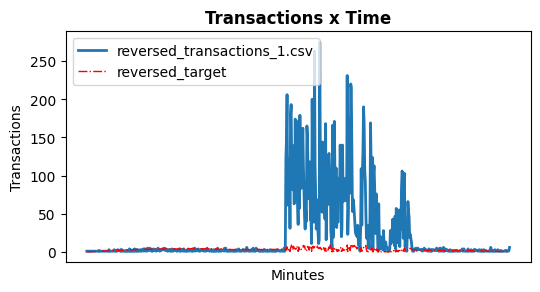

In [9]:
csv_update('transactions_1.csv')